In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
import datetime
from dateutil import parser

from pylab import rcParams
rcParams['figure.figsize'] = 15, 20

In [2]:
data_cleaned = pd.read_csv('data_cleaned.csv').iloc[:,1:]

/Users/pavankumarboinapalli/DSWorkspace/ProgramFiles/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (23,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Modifying columns names with '_' for convenience

In [3]:
def modify_col_names(df):
    data_to_modify = df.copy()
    col_name_map = {}
    for col in data_to_modify.columns:
        col_name_map[col] = "_".join(col.strip().split(' ')).replace('’','').replace('#','No').replace('.','').replace('\'','')
    
    data_to_modify.rename(columns=col_name_map,inplace=True)
    data_modified = data_to_modify.copy()
    return data_modified
    

In [4]:
data_modified = modify_col_names(data_cleaned)

## converting date type columns to pandas datetime datatype

In [5]:
def derive_datecols(df,date_cols):
    data_to_derive = df.copy()
    for col in date_cols:
        data_to_derive[col] = pd.to_datetime(data_to_derive[col],format="%m/%d/%Y %H:%M:%S %p", errors='coerce')
    data_derived = data_to_derive.copy()
    return data_derived
    
    

In [6]:
date_cols = ["Issuance_Date","Expiration_Date","Filing_Date","Job_Start_Date","DOBRunDate"]
data_derived = derive_datecols(data_modified,date_cols)

In [7]:
#data_derived.to_csv('data_derived.csv')

In [8]:
data_derived.columns

Index(['BOROUGH', 'Bin_No', 'House_No', 'Street_Name', 'Job_No', 'Job_doc_No',
       'Job_Type', 'Self_Cert', 'Block', 'Lot', 'Community_Board', 'Zip_Code',
       'Bldg_Type', 'Residential', 'Work_Type', 'Permit_Status',
       'Filing_Status', 'Permit_Type', 'Permit_Sequence_No', 'Permit_Subtype',
       'Site_Fill', 'Filing_Date', 'Issuance_Date', 'Expiration_Date',
       'Job_Start_Date', 'Permittees_First_Name', 'Permittees_Last_Name',
       'Permittees_Business_Name', 'Permittees_Phone_No',
       'Permittees_License_Type', 'Permittees_License_No',
       'Act_as_Superintendent', 'Superintendent_First_&_Last_Name',
       'Superintendent_Business_Name', 'Owners_Business_Type', 'Non-Profit',
       'Owners_Business_Name', 'Owners_First_Name', 'Owners_Last_Name',
       'Owners_House_No', 'Owners_House_Street_Name', 'Owners_House_City',
       'Owners_House_State', 'Owners_House_Zip_Code', 'Owners_Phone_No',
       'DOBRunDate', 'PERMIT_SI_NO', 'LATITUDE', 'LONGITUDE',
       'C

In [9]:
s = data_derived[['Owners_Business_Name', 'Owners_First_Name', 'Owners_Last_Name',
       'Owners_House_No', 'Owners_House_Street_Name', 'Owners_House_City',
       'Owners_House_State', 'Owners_House_Zip_Code', 'Owners_Phone_No']]

In [10]:
data_derived.shape

(3508249, 52)

In [11]:
# days since initial permit issuance

# self cert

### Deriving New Feature called Time Taken to Issue Permit by subtracting Issue_Date with Filing_Date

In [12]:
data_derived_v2 = data_derived.copy()

In [13]:
before_shape = data_derived_v2.shape[0]
data_derived_v2.dropna(subset=date_cols,inplace=True)
after_shape = data_derived_v2.shape[0]
print("Dropped {} values with na date values".format(after_shape-before_shape))

Dropped -20014 values with na date values


In [14]:
data_derived_v2['Days_To_Issue_Permit'] = data_derived_v2['Issuance_Date'] - data_derived_v2['Filing_Date']

In [15]:
data_derived_v2['Days_To_Issue_Permit'] = data_derived_v2['Days_To_Issue_Permit'].apply(lambda x :  datetime.timedelta(0).days if x<datetime.timedelta(0) else x.days)

## Extracting Year, Month and Day Features for each date type column

In [16]:
for col in date_cols:
    data_derived_v2[col+'_Year'] = data_derived_v2[col].apply(lambda x: str(x.year))
    data_derived_v2[col+'_Month'] = data_derived_v2[col].apply(lambda x: str(x.month))
    data_derived_v2[col+'_Day'] = data_derived_v2[col].apply(lambda x: str(x.day))
    data_derived_v2[col+'_Decade'] = data_derived_v2[col].apply(lambda x: str(x.year)[0:3]+"0")
      

In [23]:

def get_Jobs_Stats_Per_borough(df,group_col,date_col):
    groups_count_by_year = []
    for group_val in df[group_col].unique():
        group_count_by_year = df.loc[df[group_col]==group_val,:].groupby([group_col,date_col+"_Year"]).size()
        group_count_by_year = group_count_by_year.reset_index().rename(columns={0:'No_of_'+date_col.split("_")[0]})
        plt.plot(group_count_by_year[date_col+'_Year'],group_count_by_year['No_of_'+date_col.split("_")[0]])
        groups_count_by_year.append(group_count_by_year)
    plt.xlabel(date_col)
    plt.ylabel('No_of_'+date_col.split("_")[0])
    plt.legend(df[group_col].unique())
    plt.xlim(0,30)


<Figure size 1440x1080 with 0 Axes>

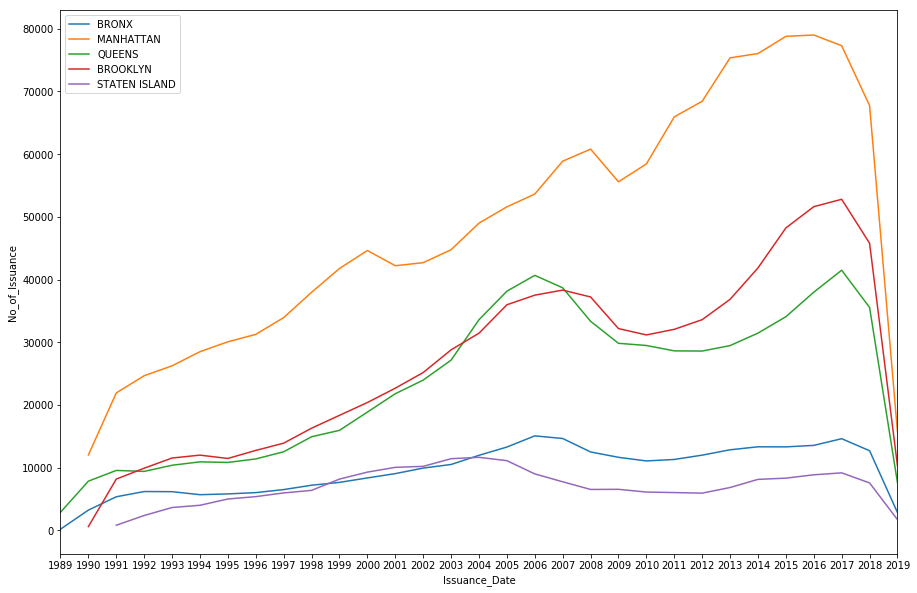

In [27]:
plt.figure(figsize=(15,10))
get_Jobs_Stats_Per_borough(data_derived_v2,"BOROUGH","Issuance_Date")

In [32]:
def get_Jobs_Stats_Per_borough_num(df,group_col,date_col,numeric_col):
    groups_count_by_year = []
    for group_val in df[group_col].unique():
        group_count_by_year = df.loc[df[group_col]==group_val,:].groupby([group_col,date_col+'_Year']).mean()
        group_count_by_year = group_count_by_year.reset_index()
        groups_count_by_year.append(group_count_by_year)
        plt.plot(group_count_by_year[date_col+'_Year'],group_count_by_year[numeric_col])        
    plt.legend(df[group_col].unique())
    plt.xlim(0,30)
    plt.ylabel("mean_"+numeric_col)
    plt.xlabel(date_col)


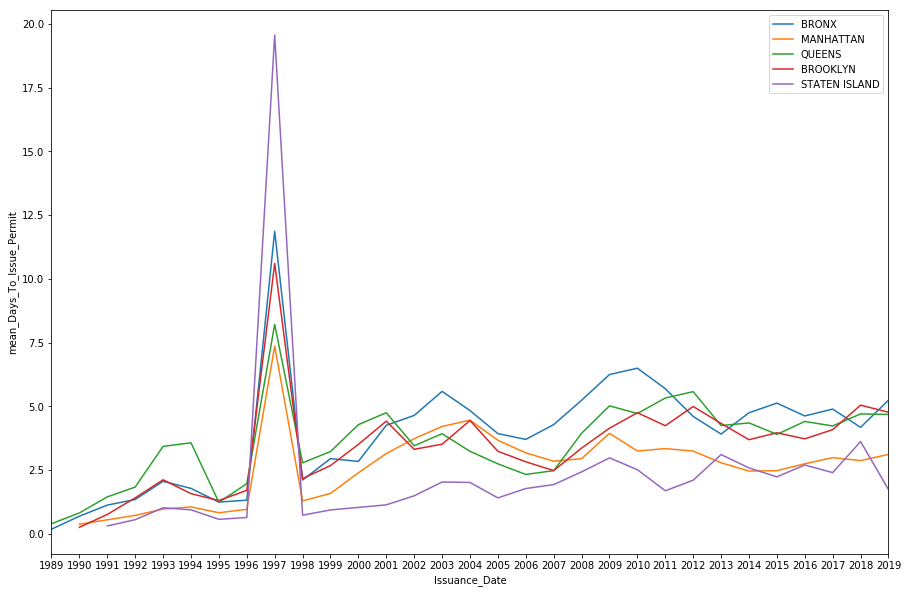

In [33]:
plt.figure(figsize=(15,10))
get_Jobs_Stats_Per_borough_num(data_derived_v2,'BOROUGH','Issuance_Date','Days_To_Issue_Permit')

#### The Peak in mean days taken to approve is peaked in 1997, because approximately 30 permits were issued in 1997 for those buildingsfor which permit request was filed in 1995 or earlier

In [21]:
data_derived_v2.loc[data_derived_v2['Issuance_Date_Year']=="1997",:].sort_values("Days_To_Issue_Permit",ascending=False)

,BOROUGH,Bin_No,House_No,Street_Name,Job_No,Job_doc_No,Job_Type,Self_Cert,Block,Lot,...,Filing_Date_Day,Filing_Date_Decade,Job_Start_Date_Year,Job_Start_Date_Month,Job_Start_Date_Day,Job_Start_Date_Decade,DOBRunDate_Year,DOBRunDate_Month,DOBRunDate_Day,DOBRunDate_Decade
3066016,BRONX,2027235,1374,ZEREGA AV,200024650,1,A1,NaN,3846,1,...,6,1990,1990,6,6,1990,2017,11,3,2010
3060027,QUEENS,4198458,101-16,106 STREET,400091574,1,A1,NaN,9423,17,...,13,1990,1990,9,13,1990,2017,11,3,2010
3058785,MANHATTAN,1007041,47,MERCER STREET,100070325,1,A2,NaN,474,16,...,26,1990,1991,2,26,1990,2017,11,3,2010
3073500,QUEENS,4052241,70-20,108 STREET,400101331,1,A2,NaN,2215,1,...,22,1990,1991,3,22,1990,2017,11,3,2010
3071565,MANHATTAN,1082488,202,CANAL STREET,100154280,1,A2,NaN,200,12,...,5,1990,1992,9,5,1990,2017,11,3,2010
3069742,BRONX,2009056,1885,UNIVERSITY AVENUE,200048563,1,A1,NaN,2879,35,...,19,1990,1991,9,19,1990,2017,11,3,2010
3062719,MANHATTAN,1017125,27,EAST 35 STREET,100272955,1,A1,NaN,865,24,...,7,1990,1991,11,7,1990,2017,11,3,2010
3057596,MANHATTAN,1008206,300,BOWERY,100259471,1,A1,NaN,521,82,...,2,1990,1992,1,2,1990,2017,11,3,2010
3072602,MANHATTAN,1079083,250,GRAND STREET,100330811,1,A2,NaN,423,26,...,28,1990,1991,10,28,1990,2017,11,3,2010
3071220,BROOKLYN,3003023,124,PACIFIC STREET,300108461,1,A2,NaN,291,14,...,15,1990,1991,11,15,1990,2017,11,3,2010


In [22]:
data_derived_v2.loc[data_derived_v2['Issuance_Date_Year']=="1998",:].sort_values("Days_To_Issue_Permit",ascending=False)

,BOROUGH,Bin_No,House_No,Street_Name,Job_No,Job_doc_No,Job_Type,Self_Cert,Block,Lot,...,Filing_Date_Day,Filing_Date_Decade,Job_Start_Date_Year,Job_Start_Date_Month,Job_Start_Date_Day,Job_Start_Date_Decade,DOBRunDate_Year,DOBRunDate_Month,DOBRunDate_Day,DOBRunDate_Decade
3018738,QUEENS,4458377,24-28,49 STREET,400107068,1,NB,NaN,746,67,...,18,1990,1991,5,30,1990,2017,11,3,2010
3012417,QUEENS,4035815,82-13,37 AVENUE,400578255,1,SG,NaN,1456,35,...,30,1990,1998,5,14,1990,2017,11,3,2010
3034576,MANHATTAN,1012845,413,9 AVENUE,100911453,1,A1,NaN,731,40,...,28,1990,1995,8,28,1990,2017,11,3,2010
3030560,MANHATTAN,1016891,390,PARK AVENUE SOUTH,101107954,1,A1,NaN,857,40,...,1,1990,1998,2,23,1990,2017,11,3,2010
3011571,MANHATTAN,1090192,47,WEST STREET,101279634,3,A2,NaN,17,18,...,29,1990,1998,5,19,1990,2017,11,3,2010
3007312,QUEENS,4044552,104-18,38 AVENUE,400511139,1,A2,NaN,1775,4,...,21,1990,1998,6,5,1990,2017,11,3,2010
3017757,BROOKLYN,3236931,6201,AVENUE U,300517475,1,A2,NaN,8405,44,...,4,1990,1998,4,21,1990,2017,11,3,2010
3039149,QUEENS,4027691,38-01,58 STREET,400514145,1,A2,NaN,1213,12,...,11,1990,1998,1,14,1990,2017,11,3,2010
3038367,QUEENS,4549110,89-07,LIBERTY AVENUE,400590400,1,NB,NaN,9109,25,...,12,1990,1996,4,12,1990,2017,11,3,2010
3034360,QUEENS,4222417,89-52,196 STREET,400616810,1,NB,NaN,10463,45,...,13,1990,1998,2,4,1990,2017,11,3,2010


## Reading Population Data

In [25]:
population_df = pd.read_csv('nyc_population.csv')

In [26]:
population_df = modify_col_names(population_df)

In [27]:
population_df['Borough'] = population_df['Borough'].apply(lambda x: str.upper(x.strip()))

In [28]:
population_cols_to_keep = ["Borough","1950","1960","1970","1980","1990","2000","2010","2020","2030","2040"]
population_df = population_df[population_cols_to_keep].iloc[1:,:]

In [29]:
population_df

,Borough,1950,1960,1970,1980,1990,2000,2010,2020,2030,2040
1,BRONX,1451277,1424815,1471701,1168972,1203789,1332650,1385108,1446788,1518998,1579245
2,BROOKLYN,2738175,2627319,2602012,2230936,2300664,2465326,2552911,2648452,2754009,2840525
3,MANHATTAN,1960101,1698281,1539233,1428285,1487536,1537195,1585873,1638281,1676720,1691617
4,QUEENS,1550849,1809578,1986473,1891325,1951598,2229379,2250002,2330295,2373551,2412649
5,STATEN ISLAND,191555,221991,295443,352121,378977,443728,468730,487155,497749,501109


In [30]:
population_df = population_df.melt(id_vars=['Borough'], value_vars=population_cols_to_keep[1:]).rename(columns={"value":"population"})

In [44]:
population_df = population_df.rename(columns={"variable":"census_decade"})

Text(0,0.5,'Borough Population')

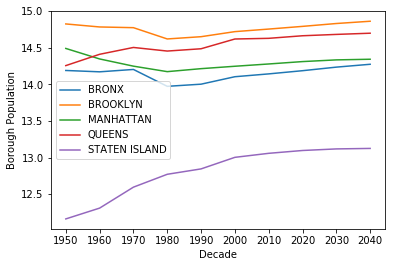

In [46]:
for borough in population_df.Borough.unique():
    Manhattan_pop = population_df.query("Borough == \"{}\"".format(borough))
    plt.plot(Manhattan_pop['census_decade'],np.log(Manhattan_pop['population']))
plt.legend(population_df.Borough.unique())
plt.xlabel('Decade')
plt.ylabel("Borough Population")

## Reading Economical Data

## Residential building permits

In [42]:
data_derived_v2.to_csv("data_derived_v2.csv")

In [47]:
population_df.to_csv('population_df.csv')